# Explainable AI for Credit Risk Detection

This notebook presents an Explainable AI (XAI) analysis for a credit risk detection model. The goal is to understand and interpret the decisions made by a machine learning model that predicts the probability of loan default.

The focus of this notebook is not only on model performance, but on explaining:
- which features influence the model globally
- why specific individual predictions are made
- how these explanations can be used to improve the model or support decision-making.

## Problem Description

The task is a binary classification problem where the goal is to predict whether a loan applicant is likely to default.

- Input: applicant financial and personal information
- Output: probability of default

Explainability is critical in this setting because credit decisions directly affect individuals and must be transparent, fair, and justifiable.


## Dataset

The dataset used is the German Credit dataset from the UCI Machine Learning Repository. It contains both numerical and categorical variables related to credit applications.

In [1]:
import pandas as pd

df = pd.read_csv("data/german_credit.csv")
df["credit_per_month"] = df["credit_amount"] / df["duration"]
df.head()

,status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status_sex,other_debtors,...,age,other_installment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target,credit_per_month
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,67,A143,A152,2,A173,1,A192,A201,0,194.833333
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,22,A143,A152,1,A173,1,A191,A201,1,123.979167
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,49,A143,A152,1,A172,2,A191,A201,0,174.666667
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,45,A143,A153,1,A173,2,A191,A201,0,187.666667
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,53,A143,A153,2,A173,2,A191,A201,1,202.916667


In [2]:
df.columns

Index(['status', 'duration', 'credit_history', 'purpose', 'credit_amount',
       'savings', 'employment', 'installment_rate', 'personal_status_sex',
       'other_debtors', 'residence_since', 'property', 'age',
       'other_installment_plans', 'housing', 'existing_credits', 'job',
       'num_dependents', 'own_telephone', 'foreign_worker', 'target',
       'credit_per_month'],
      dtype='object')

The target variable indicates whether a customer defaulted on a loan

In [3]:
X = df.drop("target", axis=1)
y = df["target"]

X.shape, y.value_counts()

((1000, 21),
 target
 0    700
 1    300
 Name: count, dtype: int64)

## Model

The model used is a tree based classifier trained using scikit learn.

In [ ]:
# !python src/train.py

In [4]:
import joblib

model = joblib.load("models/model.pkl")

In [5]:
import json

with open("mlflow_metrics.json") as f:
    data = json.load(f)

for metric, value in data.items():
    print(metric, ": ", value)

accuracy :  0.7866666666666666
recall :  0.6111111111111112
roc_auc :  0.7977248677248677
mae :  0.21333333333333335
rmse :  0.46188021535170065
f1 :  0.632183908045977


The model achieves an overall accuracy of 0.85 and a ROC AUC of approximately 0.80, which shows a strong discriminative performance.

## Global Explanation: Feature Importance

Now we will analyse the feature importance scores provided by the tree-based model. This gives a high-level view of which features influence predictions on average.


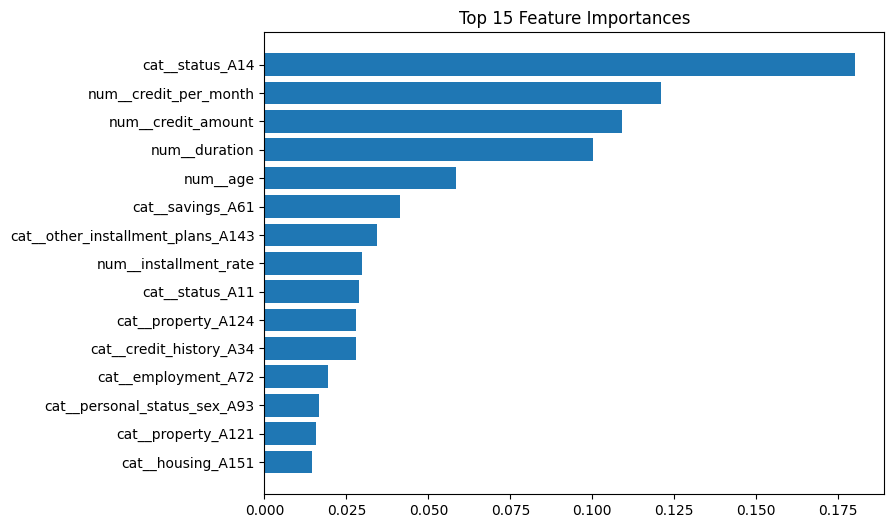

In [6]:
import numpy as np
import matplotlib.pyplot as plt

importances = model.named_steps["model"].feature_importances_
feature_names = model.named_steps["preprocessing"].get_feature_names_out()

indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title("Top 15 Feature Importances")
plt.show()

In [7]:
preprocessor = model.named_steps["preprocessing"]

categorical_features = preprocessor.transformers_[0][2]
numerical_features = preprocessor.transformers_[1][2]

feature_to_group = {}

for feature in feature_names:
    if feature.startswith("cat__"):
        for col in categorical_features:
            if feature.startswith(f"cat__{col}_"):
                feature_to_group[feature] = col
                break
    elif feature.startswith("num__"):
        base = feature.replace("num__", "")
        feature_to_group[feature] = base


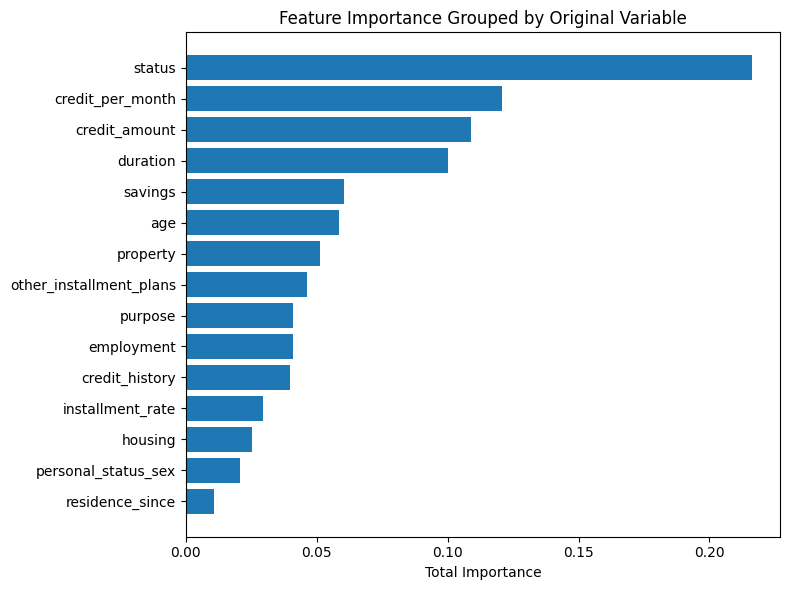

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame with feature importances
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

importance_df["group"] = importance_df["feature"].map(feature_to_group)

# Aggregate importances by original feature
grouped_importance = (
    importance_df
    .groupby("group", as_index=False)["importance"]
    .sum()
    .sort_values("importance", ascending=False)
)

# Plot top variables
plt.figure(figsize=(8, 6))
plt.barh(
    grouped_importance["group"].head(15)[::-1],
    grouped_importance["importance"].head(15)[::-1]
)
plt.xlabel("Total Importance")
plt.title("Feature Importance Grouped by Original Variable")
plt.tight_layout()
plt.show()


The analysis begins by looking at the global feature importance from the tree based model. At first, this uses the raw features created after one hot encoding, which shows exactly which specific inputs help the model make its decisions.

However, there is a catch. Many of the top features are just individual categories that came from the same original variable (like different types of account status or property).

To make things clearer, a second explanation is provided where the importance scores are grouped back into the original variables. By summing up the scores of all categories belonging to the same variable, the result is more interpretable, it's easier for a person to understand.

The aggregated analysis shows that account status and credit-related variables (like the amount, duration, etc) are the most important for the model. In comparison, personal and demographic details don't have as much influence on the final predictions. This shows that the model focuses on the applicant’s current financial situation, rather than relying on personal data.

## Global Explanation: SHAP

SHAP values provide a more theoretically grounded explanation by attributing each prediction to individual feature contributions.

We use SHAP to understand the overall behaviour of the model.


c:\Master\XIA\final-project-NatLey30\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


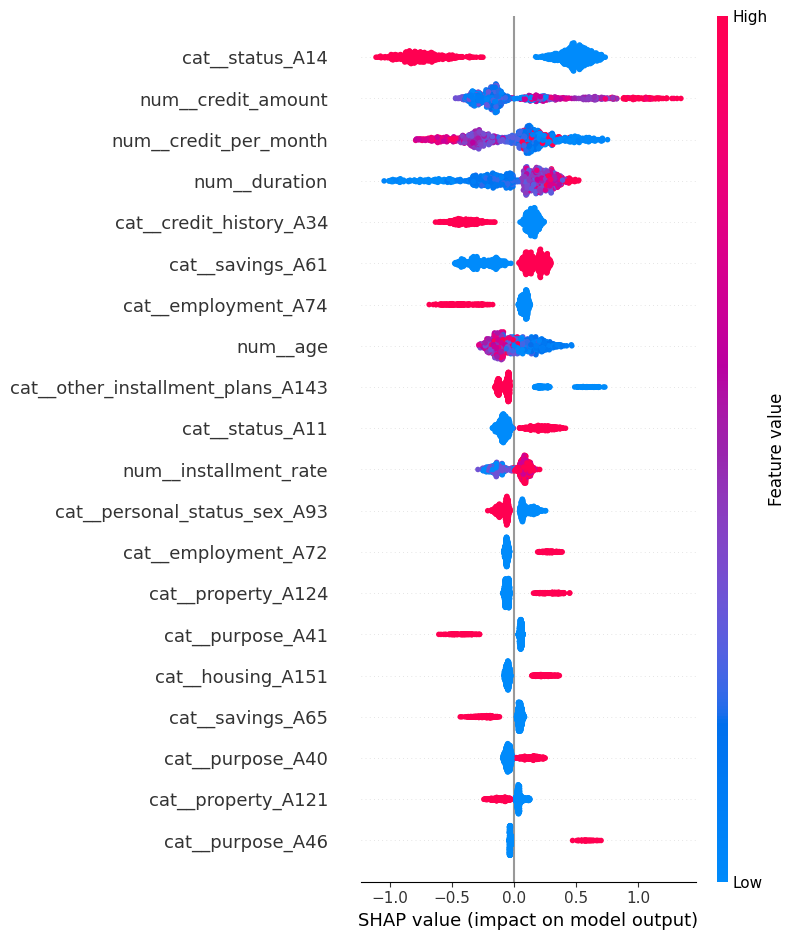

In [9]:
import shap

explainer = shap.Explainer(model.named_steps["model"])
X_transformed = model.named_steps["preprocessing"].transform(X)

shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, feature_names=feature_names)

Which concepts matter most overall?

In [10]:
feature_to_group = {}

for feature in feature_names:
    if feature.startswith("cat__"):
        # Example: cat__status_A14 → status
        base = feature.replace("cat__", "").split("_")[0]
        feature_to_group[feature] = base
    elif feature.startswith("num__"):
        # Example: num__credit_amount → credit_amount
        base = feature.replace("num__", "")
        feature_to_group[feature] = base

In [26]:
import pandas as pd
import numpy as np

shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

shap_df = pd.DataFrame({
    "feature": feature_names,
    "shap_importance": shap_abs_mean
})

shap_df["group"] = shap_df["feature"].map(feature_to_group)

grouped_shap = (
    shap_df
    .groupby("group", as_index=False)["shap_importance"]
    .sum()
    .sort_values("shap_importance", ascending=False)
)

grouped_shap.head(15)

# Plot top variables
# plt.figure(figsize=(8, 6))
# plt.barh(
#     grouped_shap["group"].head(15)[::-1],
#     grouped_shap["shap_importance"].head(15)[::-1]
# )
# plt.xlabel("Total Importance")
# plt.title("SHAP Grouped by Original Variable")
# plt.tight_layout()
# plt.show()

,group,shap_importance
19,status,0.743920
18,savings,0.321487
2,credit_amount,0.301652
5,employment,0.282891
16,purpose,0.268841
3,credit_per_month,0.267048
1,credit,0.261617
4,duration,0.255720
12,other,0.231696
15,property,0.175776


The SHAP summary plot first shows explanations based on the individual one-hot encoded features. Even though this is exactly how the model sees the data, it can be pretty hard for a person to read. This is because categorical variables get split into many different "dummy" features, making the plot look messy.

To make things easier to understand, SHAP values were also grouped together back into their original variables. This was done by summing up the average contribution (mean absolute value) of all the categories that belong to the same group. This way, the focus is on the general "concepts" that drive the predictions instead of just looking at tiny individual pieces of data.

Both of these views are useful in their own way: the ungrouped SHAP plot explains specific conditions that increase or decrease risk, while the grouped SHAP plot highlight the most influential variables overall.


The grouped SHAP analysis shows that the model’s predictions are mainly driven by financial stability and credit sustainability indicators. Account status is the most influential variable. This suggests that the model prioritizes the applicant’s current financial situation over historical or demographic attributes.

The SHAP explanations show that the model behaves in a way that makes sense for credit risk assessment. It relies on factors that actually matter, which makes it easier to trust. Instead of letting the model make all the decisions automatically, these results show it is a solid tool for supporting human decisions.

## Local Explanation: Individual Prediction

Global explanations hide individual differences. It's important to analyse why the model made a specific prediction for a single applicant.

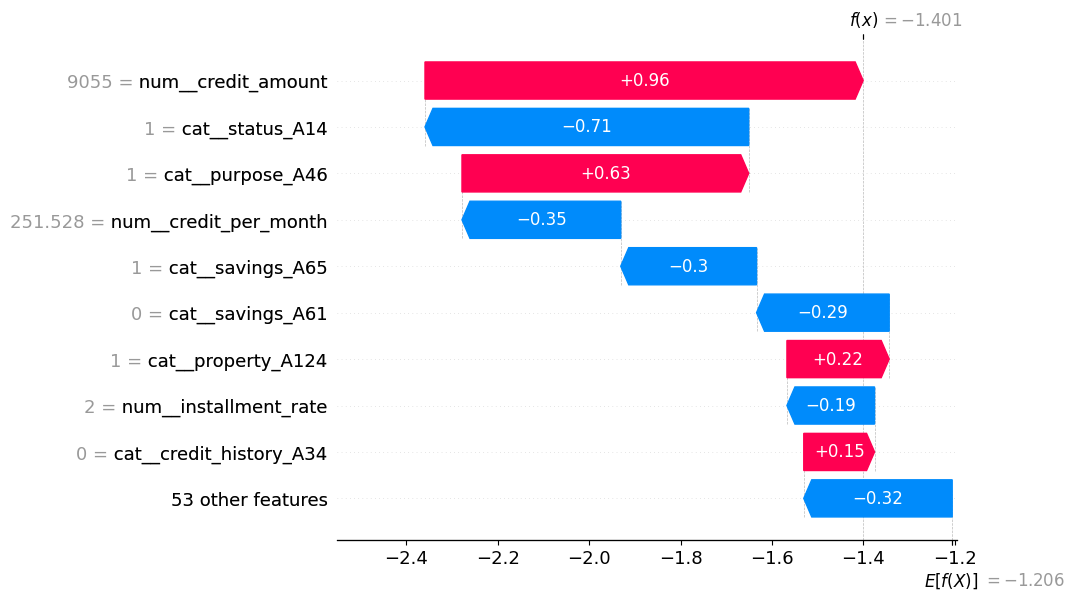

In [12]:
shap_values_named = shap.Explanation(
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=X_transformed,
    feature_names=feature_names
)

shap.plots.waterfall(shap_values_named[5], max_display=10)

Positive shap value (red) -> increases risk

Negative shap value (blue) -> reduces risk

This waterfall plot provides a detailed look at a specific applicant’s prediction, showing exactly how each feature value moves the final output. In this case, the predicted value is well below the baseline, which means the model sees a low probability of default for this person.

The analysis shows a clear balance between different factors:
- Features like a high credit amount and the specific loan purpose push the risk score up, as these usually mean higher financial exposure.
- These risks are more than offset by strong positive signals. Specifically, a favorable account status, a manageable monthly credit burden, and high savings all work together to lower the risk.

This example shows how the model balances multiple aspects of an applicant’s financial situation rather than relying on a single variable.

## Sanity Check: Feature Removal

To validate the faithfulness of explanations, we remove the most important features and observe the impact on performance.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def build_pipeline(n_estimators):
    categorical_features = [
        "credit_history", "purpose", "savings", "employment",
        "personal_status_sex", "other_debtors", "property",
        "other_installment_plans", "housing", "job",
        "own_telephone", "foreign_worker"
    ]

    numerical_features = [
        "duration", "credit_amount", "installment_rate",
        "residence_since", "age", "existing_credits",
        "num_dependents", "credit_per_month"
    ]

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
            ("num", "passthrough", numerical_features),
        ]
    )

    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=0.03,
        max_depth=3,
        min_samples_leaf=30,
        subsample=0.9,
        random_state=42
    )

    pipeline = Pipeline(
        steps=[
            ("preprocessing", preprocessor),
            ("model", model)
        ]
    )

    return pipeline

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    roc_auc_score,
    mean_absolute_error,
    root_mean_squared_error,
    f1_score
)

status_features = [col for col in X.columns if col.startswith("status")]

X_no_status = X.drop(columns=status_features)

X_train, X_test, y_train, y_test = train_test_split(
    X_no_status, y, test_size=0.3, random_state=42, stratify=y
)

model_no_status = build_pipeline(400)

model_no_status.fit(X_train, y_train)

y_proba_ns = model_no_status.predict_proba(X_test)[:, 1]
y_pred_ns = (y_proba_ns >= 0.4).astype(int)

accuracy = accuracy_score(y_test, y_pred_ns)
recall = recall_score(y_test, y_pred_ns)
roc_auc = roc_auc_score(y_test, y_proba_ns)
mae = mean_absolute_error(y_test, y_pred_ns)
rmse = root_mean_squared_error(y_test, y_pred_ns)
f1 = f1_score(y_test, y_pred_ns)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7433
Recall: 0.5444
ROC AUC: 0.7434
MAE: 0.2567
RMSE: 0.5066
F1 Score: 0.5600


To assess the faithfulness of the explanations, a sanity check was performed by removing the most influential variable identified in the global analysis (account status) and retraining the model.

After removing the account status variable and retraining the model, the ROC AUC decreased. This drop in performance indicates that account status plays a critical role in the model’s predictive capability.

This result confirms that the global explanations correctly identified an important feature.

## Counter Factual 

In [17]:
idx=5
x_cf = X.iloc[idx].copy()

base = model.predict_proba(x_cf.to_frame().T)[0, 1]

base

0.19773364471328278

In [18]:
x_cf_amount = x_cf.copy()
x_cf_amount["credit_amount"] = 6000

model.predict_proba(x_cf_amount.to_frame().T)[0, 1]

0.10389897315407567

In [27]:
x_cf_purpose = x_cf.copy()
x_cf_purpose["purpose"] = "A44"

model.predict_proba(x_cf_purpose.to_frame().T)[0, 1]


0.10724925320417909

In [30]:
x_cf_combo = x_cf.copy()
x_cf_combo["credit_amount"] = 6000
x_cf_combo["purpose"] = "A44"

model.predict_proba(x_cf_combo.to_frame().T)[0, 1]

0.0528187673637417

The SHAP analysis identified the credit amount and loan purpose as the main risk increasing factors for this case.

Reducing the requested credit amount from 9055 to 6000 led to a decrease the predicted probability of default. Similarly, changing the loan purpose to a category associated with lower risk resulted in a significant reduction.

When both changes were applied at the same time, the predicted probability dropped more.

These counterfactual explanations provide intuitive guidance for decision support and complement the global and local SHAP analyses.